In [1]:
import sys
sys.path.append('./../DIP_py')
from basic_funcs import *
from edge import *

In [2]:
img1=io.imread("./../pic/uttower1.jpg",as_gray=True)
img2=io.imread("./../pic/uttower2.jpg",as_gray=True)


In [3]:
canny_h=np.array([-0.5,0,0.5])
canny_h=canny_h.reshape((1,-1))
canny_v=np.array([[0.5],[0],[-0.5]])

dx1=convlution(img1,canny_h)
dy1=convlution(img1,canny_v)

dx2=convlution(img2,canny_h)
dy2=convlution(img2,canny_v)

(410, 617)
(412, 615)
(410, 617)
(412, 615)


In [4]:
## find the keypoint
def find_keypoint(img,dx,dy,window_size=5,k=0.04):


    ones_=np.ones((window_size,window_size))



    dx_square=dx**2
    dy_square=dy**2
    dx_dy=dx*dy

    H,W=img.shape

    m=window_size//2

    out=np.zeros((H,W))

    for i in range(m,H-m):
        for j in range(m,W-m):
            M_xx=np.sum(ones_*dx_square[i-m:i+m+1,j-m:j+m+1])
            M_yy=np.sum(ones_*dy_square[i-m:i+m+1,j-m:j+m+1])
            M_xy=np.sum(ones_*dx_dy[i-m:i+m+1,j-m:j+m+1])

            M=np.array([[M_xx,M_xy],[M_xy,M_yy]])
            
            out[i][j]=np.linalg.det(M)-k*np.trace(M)**2

    return out


In [5]:
k1=find_keypoint(img1,dx1,dy1)
k2=find_keypoint(img1,dx2,dy2)

In [6]:
from skimage.feature import corner_peaks


In [7]:
corners1=corner_peaks(k1,threshold_rel=0.01)
corners2=corner_peaks(k2,threshold_rel=0.01)

In [8]:
corners1.shape,corners2.shape

((898, 2), (1199, 2))

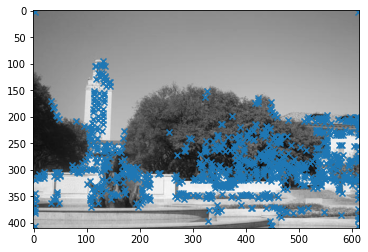

In [9]:
plt.imshow(img1,cmap="gray")
plt.scatter(corners1[:,1],corners1[:,0],marker='x')
plt.show()

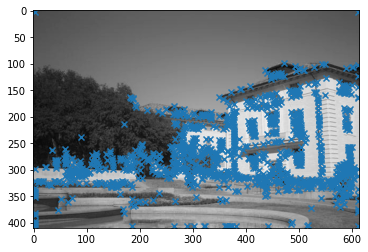

In [10]:
plt.imshow(img2,cmap="gray")
plt.scatter(corners2[:,1],corners2[:,0],marker='x')
plt.show()

In [17]:
## discript the key point

def discribe_keypoint(image,keypoints,desc_func,patch_size=16):
    """
    
    Args:
        img: input img
        keypoints: cordins of keypoints(N*2)
        desc_func: the way of discribe the keypoint
        windows_size: area used to discribe the keypoint
    return:
        features: N*m feature vectors
    
    """

    desc = []

    H,W=image.shape

    for i, kp in enumerate(keypoints):
        y, x = kp
        y1=max(y-(patch_size//2),0)
        y2=min(y+(patch_size+1)//2,H-1)

        x1=max(x-(patch_size//2),0)
        x2=min(x+(patch_size+1)//2,W-1)
        patch = image[y1:y2,
                      x1:x2]
        h,w=patch.shape

        if h<16 or w<16:
            desc.append([-1]*256)
        else:
            desc.append(desc_func(patch))

    return np.array(desc)



In [18]:
def normalize_desc(patch):
    feature = []
    ### YOUR CODE HERE
    std = np.std(patch)
    std = 1 if std == 0 else std
    feature = ((patch - np.mean(patch)) / std).flatten()
    ### END YOUR CODE
    return feature

In [19]:
features1=discribe_keypoint(img1,corners1,normalize_desc)
features2=discribe_keypoint(img2,corners2,normalize_desc)


In [40]:
def match(features1,features2):
    """find the match between features1 and features2


    return:
        match_lst: each element [x,y] x is the index in f1, y is the index in f2 
    
    """
    match_lst=[]
    for i in range(len(features1)):
        temp=np.sum((features2-features1[i])**2,axis=1)
        A, B = np.partition(temp, 1)[0: 2]
        if A/B<0.5:
            match_lst.append([i,np.argmin(temp)])
    return np.array(match_lst)
    

In [41]:
match_lst=match(features1,features2)

/tmp/ipykernel_2698/2358337714.py:13: RuntimeWarning: invalid value encountered in double_scalars
  if A/B<0.5:


In [51]:
np.pad(corners1[match_lst[:,0]],((0,0),(0,1)),'constant')

array([[305, 383,   0],
       [327, 528,   0],
       [314, 384,   0],
       [326, 531,   0],
       [329, 542,   0],
       [313, 381,   0],
       [283, 463,   0],
       [336, 470,   0],
       [316, 453,   0],
       [294, 501,   0],
       [295, 382,   0],
       [320, 441,   0],
       [325, 340,   0],
       [288, 311,   0],
       [313, 451,   0],
       [284, 470,   0],
       [320, 394,   0],
       [314, 422,   0],
       [291, 498,   0],
       [326, 503,   0],
       [314, 395,   0],
       [298, 488,   0],
       [319, 605,   0],
       [296, 481,   0],
       [296, 485,   0],
       [321, 564,   0],
       [319, 602,   0],
       [313, 339,   0],
       [321, 539,   0],
       [275, 530,   0],
       [324, 467,   0],
       [314, 336,   0],
       [276, 533,   0],
       [333, 366,   0],
       [297, 492,   0],
       [389, 466,   0],
       [323, 542,   0],
       [293, 481,   0],
       [317, 549,   0],
       [292, 336,   0],
       [319, 549,   0],
       [322, 531

In [52]:
def fit_affine_matrix(p1, p2):
    """ Fit affine matrix such that p2 * H = p1
    Hint:
        You can use np.linalg.lstsq function to solve the problem.
    Args:
        p1: an array of shape (M, P)
        p2: an array of shape (M, P)
    Return:
        H: a matrix of shape (P, P) that transform p2 to p1.
    """

    assert (p1.shape[0] == p2.shape[0]),\
        'Different number of points in p1 and p2'
    p1 = np.pad(p1,((0,0),(0,1)),'constant')
    p2 = np.pad(p2,((0,0),(0,1)),'constant')

    ### YOUR CODE HERE
    H = np.linalg.lstsq(p2, p1, rcond=None)[0]
    ### END YOUR CODE

    # Sometimes numerical issues cause least-squares to produce the last
    # column which is not exactly [0, 0, 1]
    H[:,2] = np.array([0, 0, 1])
    return H

In [95]:
def ransac(match_lst,corners1,corners2,threshold=30,num_iter=100):
    N=len(match_lst)


    sample_num=int(N*0.2)

    for i in range(num_iter):
        # random sample some samples
        idx=np.random.choice(range(N),sample_num)

        max_inlier=0
        res_H=None

        # compute affine matrix
        H=fit_affine_matrix(corners2[match_lst[idx][:,1]],corners1[match_lst[idx][:,0]])

        # compute num of inliers in samples did not choosed
        cor1_paded=np.pad(corners1,((0,0),(0,1)),"constant")
        cor2_paded=np.pad(corners2,((0,0),(0,1)),"constant")

        temp=np.sum((cor1_paded[match_lst[:,0]]@H)[:,:1]-cor2_paded[match_lst[:,1]][:,:1],axis=1)
        num_inliers=np.sum(temp<threshold)

        if num_inliers>max_inlier:
            max_inlier=num_inliers
            res_H=H
        
    return res_H



In [97]:
H=ransac(match_lst,corners1,corners2)

In [98]:
H

array([[ 0.90885336, -0.67842275,  0.        ],
       [ 0.01794969,  0.86332185,  0.        ],
       [ 0.        ,  0.        ,  1.        ]])